# STAT 430 Unsupervised Learning Final Project
## Movies on Netflix, Prime Video, Hulu and Disney+ Data Analysis
_Atharv Pathak & Jonas Reger_

### Package Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
%matplotlib inline
import statistics as st

import time
import math

from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs, load_digits
from sklearn.metrics import adjusted_rand_score, silhouette_score
# , calinski_harabaz_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from kmodes.kmodes import KModes

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet

### Movie Data Import

In [2]:
df = pd.read_csv('data/movie_archive/MoviesOnStreamingPlatforms_updated.csv', sep=',')
df.head()

,Unnamed: 0,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,Inception,2010,13+,8.8,87%,1,0,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,1,2,The Matrix,1999,18+,8.7,87%,1,0,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,2,3,Avengers: Infinity War,2018,13+,8.5,84%,1,0,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,3,4,Back to the Future,1985,7+,8.5,96%,1,0,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,1,0,1,0,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


In [3]:
df.describe()

,Unnamed: 0,ID,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Type,Runtime
count,16744.000000,16744.000000,16744.000000,16173.000000,16744.000000,16744.000000,16744.000000,16744.000000,16744.0,16152.000000
mean,8371.500000,8372.500000,2003.014035,5.902751,0.212613,0.053930,0.737817,0.033684,0.0,93.413447
std,4833.720789,4833.720789,20.674321,1.347867,0.409169,0.225886,0.439835,0.180419,0.0,28.219222
min,0.000000,1.000000,1902.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
25%,4185.750000,4186.750000,2000.000000,5.100000,0.000000,0.000000,0.000000,0.000000,0.0,82.000000
50%,8371.500000,8372.500000,2012.000000,6.100000,0.000000,0.000000,1.000000,0.000000,0.0,92.000000
75%,12557.250000,12558.250000,2016.000000,6.900000,0.000000,0.000000,1.000000,0.000000,0.0,104.000000
max,16743.000000,16744.000000,2020.000000,9.300000,1.000000,1.000000,1.000000,1.000000,0.0,1256.000000


There are 16,744 Movies listed in this dataset, with 21.26% on Netflix, 5.39% on Hulu, 73.78% on Prime Video, and 3.37% on Disney+. The average IMDb ratings is 5.90. The average movie runtime is 93.41 minutes. The movies are from the 1902-2020 time period.

In [4]:
df.isnull().sum(axis = 0)

Unnamed: 0             0
ID                     0
Title                  0
Year                   0
Age                 9390
IMDb                 571
Rotten Tomatoes    11586
Netflix                0
Hulu                   0
Prime Video            0
Disney+                0
Type                   0
Directors            726
Genres               275
Country              435
Language             599
Runtime              592
dtype: int64

There is a considerable amount of missing data, especially in the Rotten Tomatoes column. This column could be removed, but we could potentially use the known ratings in a supervised learning approach to predict ratings where they are unknown, although the train dataset may only make up approximately 1/3 of the dataset so it's not optimal.

In [5]:
df.shape

(16744, 17)

## Text Separation

In [6]:
X = df.copy()
XN = X.dropna()
print(XN.shape)
print(1-XN.shape[0]/df.shape[0])

(3301, 17)
0.8028547539417105


80.29% of the rows in the dataset contains a missing value.

### Text separation for Language Column

There is a maximum of 10 unique languages per movie. There are 178 languages (179 including 'Unknown')

### Text Separation for Director Column

There is a maximum of 28 unique Directors per movie. There are 12453 Directors (12454 including 'Unknown')

### Text Separation for Genres Column

There is a maximum of 9 unique Directors per movie. There are 27 Directors (28 including 'Unknown')

### Text separation for Country Column

In [7]:
C = X['Country'].replace(np.nan, "Unknown")

cou = []
cou_ct = []
large = 0
n = len(C)
for i in range(0, n):
    x = C[i].split(",")
    if (len(x) > large):
        large = len(x)
    else:
        pass
#     print(x.split(","))
    for j in range(0, len(x)):
        cou_ct.append(x[j])
        if (x[j] in cou):
            pass
        else:
            cou.append(x[j])
#     print(i)

print(large)
print(len(cou))

pd.Series(cou_ct).value_counts().head(25)

27
169


United States     10486
United Kingdom     1713
India              1157
Canada             1117
France              741
Germany             498
Unknown             435
Italy               417
Spain               329
Australia           321
Hong Kong           269
Japan               266
China               189
Mexico              183
South Korea         162
Belgium             151
Ireland             128
Sweden              118
Netherlands         116
Denmark             113
Argentina           106
Philippines          94
Turkey               88
South Africa         86
Taiwan               80
dtype: int64

There is a maximum of 27 unique Directors per movie. There are 168 Directors (169 including 'Unknown')

### Movie Runtime

In [8]:
# sns.distplot(C)

### Dropping Rotten Tomatoes

In [9]:
Y = df.copy()
Y = Y.drop('Rotten Tomatoes', axis=1)

YN = Y.dropna()
print(YN.shape)
print(1-YN.shape[0]/df.shape[0])

(7046, 16)
0.579192546583851


Removing 'Rotten Tomatoes' column reduces the percentage of rows in the dataset contains a missing value to 57.92%.

### Looking at possible relationship between missing values and production years

<AxesSubplot:xlabel='Year', ylabel='Density'>

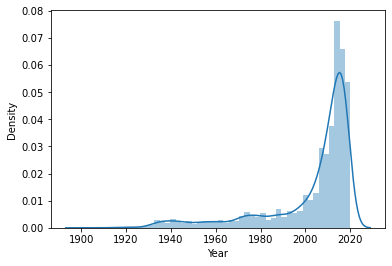

In [10]:
sns.distplot(df['Year'])

### Looking at Rotten Tomatoes

<AxesSubplot:xlabel='Year', ylabel='Density'>

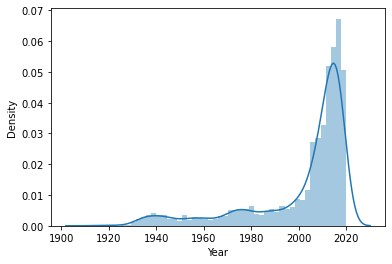

In [11]:
# rows_with_nan = [index for index, row in df.iterrows() if row.isnull().any()]
index = df.loc[pd.isna(df["Rotten Tomatoes"]), :].index
RT_nan_years = df['Year'][index]
sns.distplot(RT_nan_years)

Not a lot of differences overall

## Modifying dataset

In [99]:
DF = df.copy()
DF.head()

,Unnamed: 0,ID,Title,Year,Age,IMDb,Rotten Tomatoes,...,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,Inception,2010,13+,8.8,87%,...,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,1,2,The Matrix,1999,18+,8.7,87%,...,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,2,3,Avengers: Infinity War,2018,13+,8.5,84%,...,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,3,4,Back to the Future,1985,7+,8.5,96%,...,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,...,0,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


In [100]:
DF['Runtime'] = DF['Runtime'].replace(np.nan, st.mean(DF['Runtime']))
DF = DF.drop(['Rotten Tomatoes', 'ID', 'Unnamed: 0', 'Type'], axis=1)
DF = DF.dropna()
DF.reset_index(drop=True, inplace=True)
DF.head()

,Title,Year,Age,IMDb,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime
0,Inception,2010,13+,8.8,1,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,The Matrix,1999,18+,8.7,1,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,Avengers: Infinity War,2018,13+,8.5,1,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,Back to the Future,1985,7+,8.5,1,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,"The Good, the Bad and the Ugly",1966,18+,8.8,1,0,1,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


### Genres Data Frame

In [60]:
C = DF['Genres']
temp = pd.DataFrame(C)

lst = []
n = len(C)

for i in range(0, n):
    x = C[i].split(",")
    for j in range(0, len(x)):
        if (x[j] not in lst):
            lst.append(x[j])
            temp[x[j]] = ""
        temp.iloc[i, temp.columns.get_loc(x[j])] = 1

GENRE = temp.replace("", 0).drop(temp.columns[0], axis=1)

pd.set_option('display.max_columns', None)
print(GENRE.shape)
GENRE.head(15)

(7046, 25)


,Action,Adventure,Sci-Fi,Thriller,Comedy,Western,Animation,Family,Biography,Drama,Music,War,Crime,Fantasy,Romance,History,Mystery,Sport,Documentary,Musical,News,Horror,Short,Film-Noir,Reality-TV
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Country Data Frame

In [61]:
C = DF['Country']
temp = pd.DataFrame(C)

lst = []
n = len(C)

for i in range(0, n):
    x = C[i].split(",")
    for j in range(0, len(x)):
        if (x[j] not in lst):
            lst.append(x[j])
            temp[x[j]] = ""
        temp.iloc[i, temp.columns.get_loc(x[j])] = 1

COUNTRY = temp.replace("", 0).drop(temp.columns[0], axis=1)

pd.set_option('display.max_columns', 15)
print(COUNTRY.shape)
COUNTRY.head(15)

(7046, 125)


,United States,United Kingdom,Italy,Spain,West Germany,France,Poland,...,Burkina Faso,Trinidad and Tobago,Bahamas,Tanzania,Kazakhstan,Angola,Botswana
0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0
4,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0
6,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0


### Language Data Frame

In [62]:
C = DF['Language']
temp = pd.DataFrame(C)

lst = []
n = len(C)

for i in range(0, n):
    x = C[i].split(",")
    for j in range(0, len(x)):
        if (x[j] not in lst):
            lst.append(x[j])
            temp[x[j]] = ""
        temp.iloc[i, temp.columns.get_loc(x[j])] = 1

LANGUAGE = temp.replace("", 0).drop(temp.columns[0], axis=1)

pd.set_option('display.max_columns', 15)
print(LANGUAGE.shape)
LANGUAGE.head(15)

(7046, 131)


,English,Japanese,French,Italian,Spanish,German,Russian,...,Brazilian Sign Language,Quechua,Kudmali,Masai,Dyula,Nama,North American Indian
0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0
5,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0
6,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0
7,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0
8,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0
9,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0


### Director Data Frame

In [63]:
C = DF['Directors']
temp = pd.DataFrame(C)

lst = []
n = len(C)

for i in range(0, n):
    x = C[i].split(",")
    for j in range(0, len(x)):
        if (x[j] not in lst):
            lst.append(x[j])
            temp[x[j]] = ""
        temp.iloc[i, temp.columns.get_loc(x[j])] = 1

DIRECTORS = temp.replace("", 0).drop(temp.columns[0], axis=1)

pd.set_option('display.max_columns', 15)
print(DIRECTORS.shape)
DIRECTORS.head(15)

(7046, 5725)


,Christopher Nolan,Lana Wachowski,Lilly Wachowski,Anthony Russo,Joe Russo,Robert Zemeckis,Sergio Leone,...,Daniel M. Smith,Charles L. Draper,Russ Mayberry,Larry Lansburgh,Nick Marck,Bernard McEveety,Dereck Joubert
0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0


### Counts in each Data Frame

In [77]:
GENRE.sum()

Action         1407
Adventure      1016
Sci-Fi          682
Thriller       1724
Comedy         2291
Western         195
Animation       437
Family          974
Biography       375
Drama          3230
Music           253
War             235
Crime           907
Fantasy         660
Romance        1056
History         267
Mystery         589
Sport           204
Documentary     690
Musical         204
News             29
Horror         1076
Short            73
Film-Noir         6
Reality-TV        1
dtype: int64

<AxesSubplot:ylabel='Count'>

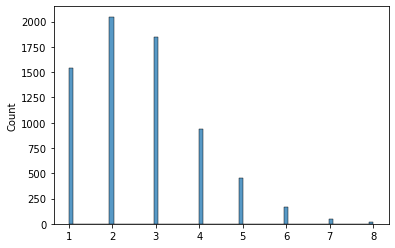

In [87]:
sns.histplot(GENRE.sum(axis=1))

In [83]:
COUNTRY.sum()

United States     5061
United Kingdom     818
Italy              154
Spain              156
West Germany        30
                  ... 
Bahamas              1
Tanzania             1
Kazakhstan           1
Angola               1
Botswana             1
Length: 125, dtype: int64

<AxesSubplot:ylabel='Count'>

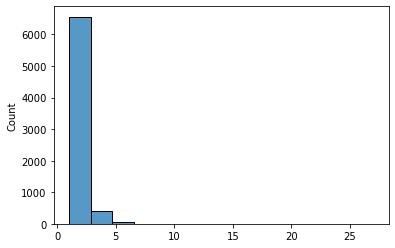

In [88]:
sns.histplot(COUNTRY.sum(axis=1))

In [67]:
LANGUAGE.sum()

English                  6219
Japanese                  148
French                    384
Italian                   196
Spanish                   409
                         ... 
Kudmali                     1
Masai                       1
Dyula                       1
Nama                        1
North American Indian       1
Length: 131, dtype: int64

<AxesSubplot:ylabel='Count'>

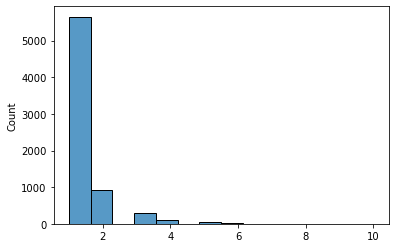

In [89]:
sns.histplot(LANGUAGE.sum(axis=1))

In [68]:
DIRECTORS.sum()

Christopher Nolan    3
Lana Wachowski       4
Lilly Wachowski      4
Anthony Russo        4
Joe Russo            4
                    ..
Russ Mayberry        1
Larry Lansburgh      1
Nick Marck           1
Bernard McEveety     1
Dereck Joubert       1
Length: 5725, dtype: int64

<AxesSubplot:ylabel='Count'>

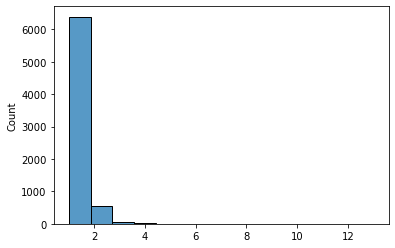

In [90]:
sns.histplot(DIRECTORS.sum(axis=1))

In [105]:
X = DF.copy()
X = X.drop(['Genres', 'Country', 'Language', 'Directors'], axis=1)
X['Total Genres'] = GENRE.sum(axis=1)
X['Total Countries'] = COUNTRY.sum(axis=1)
X['Total Languages'] = LANGUAGE.sum(axis=1)
X['Total Directors'] = DIRECTORS.sum(axis=1)
print(X.shape)
X.head()

(7046, 13)


,Title,Year,Age,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,Total Genres,Total Countries,Total Languages,Total Directors
0,Inception,2010,13+,8.8,1,0,0,0,148.0,4,2,3,1
1,The Matrix,1999,18+,8.7,1,0,0,0,136.0,2,1,1,2
2,Avengers: Infinity War,2018,13+,8.5,1,0,0,0,149.0,3,1,1,2
3,Back to the Future,1985,7+,8.5,1,0,0,0,116.0,3,1,1,1
4,"The Good, the Bad and the Ugly",1966,18+,8.8,1,0,1,0,161.0,1,3,1,1


In [108]:
X[['Netflix', 'Hulu', 'Prime Video', 'Disney+']].sum()

Netflix        1609
Hulu            567
Prime Video    4761
Disney+         489
dtype: int64

In [111]:
Everything = pd.concat([X, GENRE, COUNTRY, LANGUAGE, DIRECTORS], axis=1)
print(Everything.shape)
Everything.head()

(7046, 6019)


,Title,Year,Age,IMDb,Netflix,Hulu,Prime Video,...,Daniel M. Smith,Charles L. Draper,Russ Mayberry,Larry Lansburgh,Nick Marck,Bernard McEveety,Dereck Joubert
0,Inception,2010,13+,8.8,1,0,0,...,0,0,0,0,0,0,0
1,The Matrix,1999,18+,8.7,1,0,0,...,0,0,0,0,0,0,0
2,Avengers: Infinity War,2018,13+,8.5,1,0,0,...,0,0,0,0,0,0,0
3,Back to the Future,1985,7+,8.5,1,0,0,...,0,0,0,0,0,0,0
4,"The Good, the Bad and the Ugly",1966,18+,8.8,1,0,1,...,0,0,0,0,0,0,0


In [112]:
X.describe()

,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,Total Genres,Total Countries,Total Languages,Total Directors
count,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.00000,7046.000000
mean,2004.239285,5.847559,0.228357,0.080471,0.675703,0.069401,97.586858,2.637099,1.334942,1.30457,1.130429
std,15.796167,1.333326,0.419803,0.272041,0.468145,0.254153,21.929089,1.334111,0.868136,0.74407,0.605995
min,1902.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.00000,1.000000
25%,1999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,87.000000,2.000000,1.000000,1.00000,1.000000
50%,2010.000000,6.000000,0.000000,0.000000,1.000000,0.000000,95.000000,2.000000,1.000000,1.00000,1.000000
75%,2015.000000,6.800000,0.000000,0.000000,1.000000,0.000000,106.000000,3.000000,1.000000,1.00000,1.000000
max,2020.000000,9.100000,1.000000,1.000000,1.000000,1.000000,260.000000,8.000000,27.000000,10.00000,13.000000
